# **Trabalho 1 SSC0964 - Introdução à Computação no Mercado Financeiro**

---

Amanda Caroline de Oliveira Pires - 12559090

Emanuel Victor da Silva Favorato - 12558151

Rafael Zimmer - 12542612

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Código para ler e extrair um arquivo zip

file_name = 'Dados_Economatica_v1.zip'
with zipfile.ZipFile(file_name, 'r') as file:
    file.printdir()

    print('Extracting all the files now...')
    file.extractall()
    print('Done!')

File Name                                             Modified             Size
Dados_Economatica_v1/                          2023-05-02 17:55:46            0
Dados_Economatica_v1/Dados-Base.xlsx           2022-05-24 16:59:50        20928
Dados_Economatica_v1/Dados-Comp-IBRX.xlsx      2022-04-16 15:02:06       216584
Dados_Economatica_v1/Dados-Fechamento.xlsx     2022-04-12 09:30:36       590147
Dados_Economatica_v1/Dados-Momentum-12.xlsx    2022-04-13 15:04:40       449167
Dados_Economatica_v1/Dados-PVP.xlsx            2022-04-12 14:53:26       453507
Dados_Economatica_v1/Dados-ROIC-A2.xlsx        2022-04-12 10:31:40       311898
Dados_Economatica_v1/Dados-Val-Merc.xlsx       2022-04-12 14:44:46       435342
Dados_Economatica_v1/Dados-Vol-12.xlsx         2022-04-12 10:56:56       456929
Extracting all the files now...
Done!


In [ ]:
#Preços de fechamento dos ativos
fechamento=pd.read_excel('Dados_Economatica_v1/Dados-Fechamento.xlsx', engine='openpyxl')
fechamento.set_index(keys = 'Data', inplace = True)

#Indices de referência (Ibov, IBX, SELIC...)
referencias=pd.read_excel('Dados_Economatica_v1/Dados-Base.xlsx', engine='openpyxl')
referencias.set_index(keys = 'Data', inplace = True)

# Fator Qualidade (ROIC das empresas)
fator_ROIC=pd.read_excel('Dados_Economatica_v1/Dados-ROIC-A2.xlsx', engine='openpyxl')
fator_ROIC.set_index(keys = 'Data', inplace = True)
ranked_ROIC=fator_ROIC.rank(axis=1, numeric_only=True, ascending=False, method='first')

#Fator Volatilidade (Volatilidade em 12 meses)
fator_Vol=pd.read_excel('Dados_Economatica_v1/Dados-Vol-12.xlsx', engine='openpyxl')
fator_Vol.set_index(keys = 'Data', inplace = True)
ranked_Vol=fator_Vol.rank(axis=1, numeric_only=True, ascending=True, method='first')

# Fator Momentum (Momentum de 12 meses)
fator_Mom=pd.read_excel('Dados_Economatica_v1/Dados-Momentum-12.xlsx', engine='openpyxl')
fator_Mom.set_index(keys = 'Data', inplace = True)
ranked_Mom=fator_Mom.rank(axis=1, numeric_only=True, ascending=False, method='first')

#Fator Tamanho (Valor de mercado das empresas)
fator_Val_Merc=pd.read_excel('Dados_Economatica_v1/Dados-Val-Merc.xlsx', engine='openpyxl')
fator_Val_Merc.set_index(keys = 'Data', inplace = True)
ranked_Val_Merc=fator_Val_Merc.rank(axis=1, numeric_only=True, ascending=True, method='first')

#Fator Valor (Preço / Valor Patrimonial)
fator_PVP=pd.read_excel('Dados_Economatica_v1/Dados-PVP.xlsx', engine='openpyxl')
fator_PVP.set_index(keys = 'Data', inplace = True)
ranked_PVP=fator_PVP.rank(axis=1, numeric_only=True, ascending=True, method='first')

In [ ]:
#Seleção das ações

data_inicial = 13 #  13 = 01/2005
data_final   = data_inicial + 203
step_port = 1
step_eval = 1
colunas = 291 #len(comp_indice.columns)

#Retorno: portfólio
def SelPort1(port_ranked_1, param_1a, param_1b):

    port_ranked_final = port_ranked_1.copy()
    port_ranked_final.loc[:, :] = 0

    for lin in range(data_inicial, data_final, step_port):
        for col in range(0, colunas):
            if ((port_ranked_1.iat[lin-1, col]  >= param_1a) and (port_ranked_1.iat[lin-1, col]  <= param_1b)):
                port_ranked_final.iat[lin-1, col] = 1

    return port_ranked_final

#Seleção das ações que compõe um portfólio com 2 fatores.

def SelPort2Par(ranking_1, high_1, ranking_2, high_2):
  colunas = len(ranking_1.columns)
  port_ranked_final = pd.DataFrame(np.zeros_like(ranking_1))

  for row in range(data_inicial, data_final, step_port):
    for col in range(0, colunas):
      if ((ranking_1.iat[row - 1, col]  >= 1) and (ranking_1.iat[row - 1, col]  <= high_1) and
          (ranking_2.iat[row - 1, col]  >= 1) and (ranking_2.iat[row - 1, col]  <= high_2)):
        port_ranked_final.iat[row - 1, col] = 1

  return port_ranked_final

#Avaliação de um portfólio.

def EvalPort(port, fechamento):
    port_acc_vet = []
    port_chg_vet = []
    port_ddown_vet = []

    colunas = len(port.columns)

    port_acc = 1.0
    port_acc_vet.append(1.0)
    cost_trans = 0.0006
    #cost_trans = 0.0005 + (0.004*step_eval/12)

    for lin in range(data_inicial, data_final, step_eval):
        cont = 0.0
        rent = 0.0
        for col in range(0, colunas):
            if (port.iat[lin-1, col] > 0 and fechamento.iat[lin-1, col]>0 and fechamento.iat[lin-1+step_eval, col]>0):
                rent = rent + (fechamento.iat[lin-1+step_eval,col]/fechamento.iat[lin-1,col]-1)*(port.iat[lin-1, col])
                cont = cont + port.iat[lin-1, col]
        if (cont == 0):
          return [1,1], [1,1], [0,0], 0, 0.000001
        port_acc = port_acc * (1.0 + rent/cont - cost_trans)
        port_chg_vet.append(rent/cont - cost_trans)
        port_acc_vet.append(port_acc)
        port_ddown_vet.append(port_acc/(np.max(port_acc_vet))-1)

    ret_aa = pow(port_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(port_chg_vet)*((12/step_eval)**(1/2))
    return port_acc_vet, port_chg_vet, port_ddown_vet, ret_aa, vol_aa

#Avaliação de um índice de referência.

def EvalRef(ref, ind):
    ref_acc_vet = []
    ref_chg_vet = []
    ref_ddown_vet = []

    ref_acc = 1.0
    ref_acc_vet.append(1.0)

    for lin in range(data_inicial, data_final, step_eval):
        rent = ref.iat[lin-1+step_eval,ind]/ref.iat[lin-1,ind]
        ref_acc = ref_acc * rent
        ref_chg_vet.append(rent-1)
        ref_acc_vet.append(ref_acc)
        ref_ddown_vet.append(ref_acc/(np.max(ref_acc_vet))-1)

    ret_aa = pow(ref_acc, 12/(data_final-data_inicial))-1
    vol_aa = np.std(ref_chg_vet)*((12/step_eval)**(1/2))
    return ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa, vol_aa

In [ ]:
# Cálculo de rentabilidade / volatilidade / drawdown da SELIC
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 2)
print("Ref SELIC:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do Ibovespa
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 0)
print("Ref Ibov:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

# Cálculo de rentabilidade / volatilidade / drawdown do IBX
ref_acc_vet, ref_chg_vet, ref_ddown_vet, ret_aa_ref, vol_aa_ref = EvalRef(referencias, 1)
print("Ref IBX:\nRet. Acc.:",round(ref_acc_vet[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa_ref*100,2), "% Vol.:", round(vol_aa_ref*100,2), "% Ret/Vol:", round(ret_aa_ref/vol_aa_ref, 2), "DDown:", round(np.min(ref_ddown_vet)*100,2), "%")

Ref SELIC:
Ret. Acc.: 415.58 % Ret. Anual.: 10.18 % Vol.: 1.11 % Ret/Vol: 9.21 DDown: 0.0 %
Ref Ibov:
Ret. Acc.: 289.05 % Ret. Anual.: 8.36 % Vol.: 23.14 % Ret/Vol: 0.36 DDown: -49.59 %
Ref IBX:
Ret. Acc.: 456.54 % Ret. Anual.: 10.68 % Vol.: 22.43 % Ret/Vol: 0.48 DDown: -49.74 %


In [ ]:
ranked = SelPort1(ranked_Vol, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked, fechamento)
print("Port :\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port :
Ret. Acc.: 597.4 % Ret. Anual.: 12.17 % Vol.: 17.3 % Ret/Vol: 0.7 DDown: -33.37 %


In [ ]:
ranked = SelPort1(ranked_ROIC, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked, fechamento)
print("Port :\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port :
Ret. Acc.: 649.28 % Ret. Anual.: 12.64 % Vol.: 21.05 % Ret/Vol: 0.6 DDown: -48.83 %


In [ ]:
ranked = SelPort1(ranked_PVP, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked, fechamento)
print("Port :\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port :
Ret. Acc.: 507.7 % Ret. Anual.: 11.26 % Vol.: 29.23 % Ret/Vol: 0.39 DDown: -76.25 %


In [ ]:
ranked = SelPort1(ranked_Val_Merc, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked, fechamento)
print("Port :\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port :
Ret. Acc.: 218.54 % Ret. Anual.: 7.09 % Vol.: 30.74 % Ret/Vol: 0.23 DDown: -73.9 %


In [ ]:
ranked = SelPort1(ranked_Mom, 0, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked, fechamento)
print("Port :\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")

Port :
Ret. Acc.: 1067.06 % Ret. Anual.: 15.63 % Vol.: 22.0 % Ret/Vol: 0.71 DDown: -46.05 %


In [ ]:
ranked1 = SelPort2Par(ranked_Vol, 30, ranked_Mom, 30)
port_acc_vet1, port_chg_vet1, port_ddown_vet1, ret_aa1, vol_aa1 = EvalPort(ranked1, fechamento)
print("Port 1:\nRet. Acc.:",round(port_acc_vet1[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa1*100,2), "% Vol.:", round(vol_aa1*100,2), "% Ret/Vol:", round(ret_aa1/vol_aa1, 2), "DDown:", round(np.min(port_ddown_vet1)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet1, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

Port 1:
Ret. Acc.: 2894.82 % Ret. Anual.: 22.26 % Vol.: 18.76 % Ret/Vol: 1.19 DDown: -30.97 %
Port Alpha: 14.29 %, Beta: 0.61


In [ ]:
ranked2 = SelPort2Par(ranked_PVP, 40, ranked_ROIC, 40)
port_acc_vet2, port_chg_vet2, port_ddown_vet2, ret_aa2, vol_aa2 = EvalPort(ranked2, fechamento)
print("Port 2:\nRet. Acc.:",round(port_acc_vet2[-1]*100-100, 2) ,"% Ret. Anual.:",round(ret_aa2*100,2), "% Vol.:", round(vol_aa2*100,2), "% Ret/Vol:", round(ret_aa2/vol_aa2, 2), "DDown:", round(np.min(port_ddown_vet2)*100,2), "%")
beta, alpha = np.polyfit(ref_chg_vet, port_chg_vet2, 1)
print("Port Alpha:",round(alpha*(12/step_eval)*100,2),"%, Beta:", round(beta,2))

Port 2:
Ret. Acc.: 2498.35 % Ret. Anual.: 21.23 % Vol.: 26.01 % Ret/Vol: 0.82 DDown: -60.37 %
Port Alpha: 11.19 %, Beta: 0.91


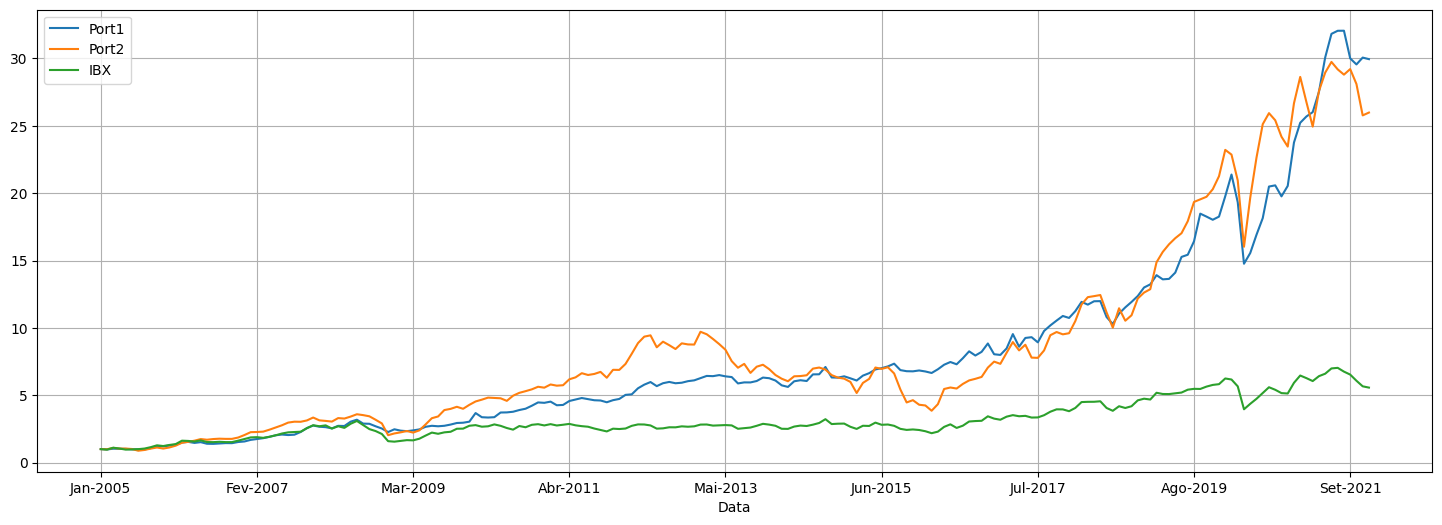

In [ ]:
#Evolução das quotas de um portfólio e de uma referência (IBX) com base 1
final_df = pd.DataFrame(index = ranked_ROIC.iloc[data_inicial:data_final+1].index)
final_df['Port1'] = port_acc_vet1
final_df['Port2'] = port_acc_vet2
final_df['IBX'] = ref_acc_vet
final_df.iloc[0:].plot(figsize=(18,6), grid=True);

Observa-se, a partir do gráfico acima, que o portifólio 2, de maior volatilidade, apresenta melhor desempenho do que o portifólio 1, de menor volatilidade, em períodos em que a inflação e os juros são mais baixos. Entretanto, em períodos em que o IPCA e a taxa SELIC sobem, o primeiro portifólio apresenta melhor desempenho, muitas vezes seguindo uma trajetória de crescimento, enquanto o portifólio 2 tende à estagnação ou a quedas. Analisando a imagem abaixo e o gráfico, é possível observar a influência dos juros e da inflação sobre o desempenho do segundo portifólio.

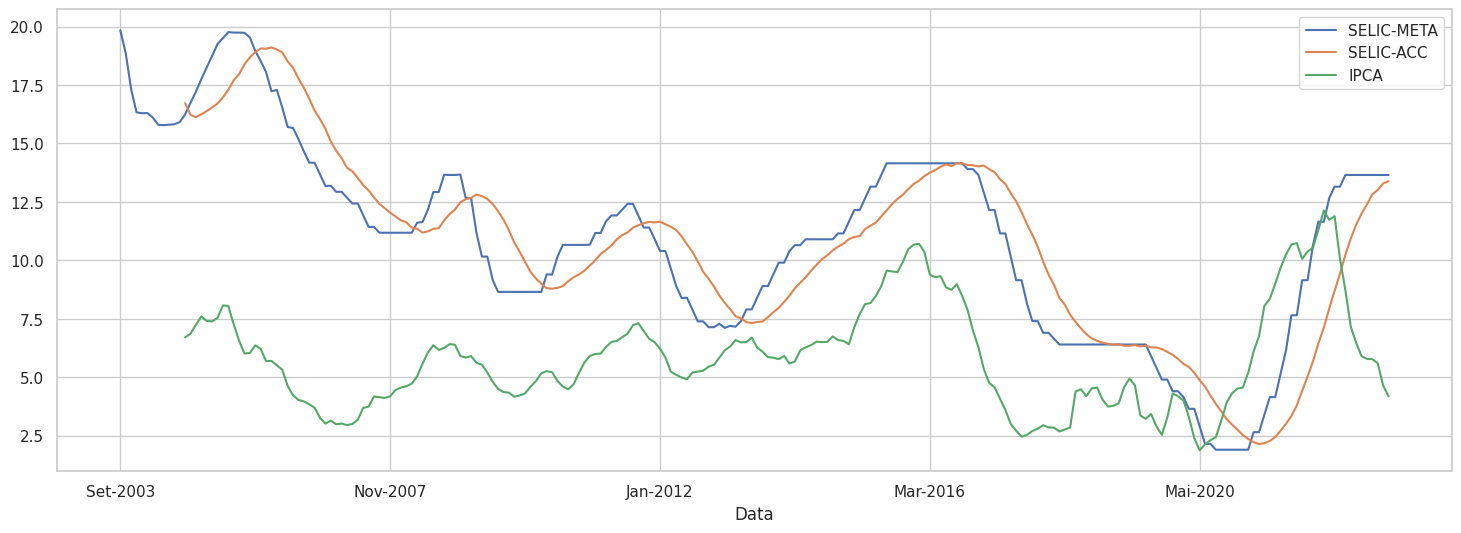





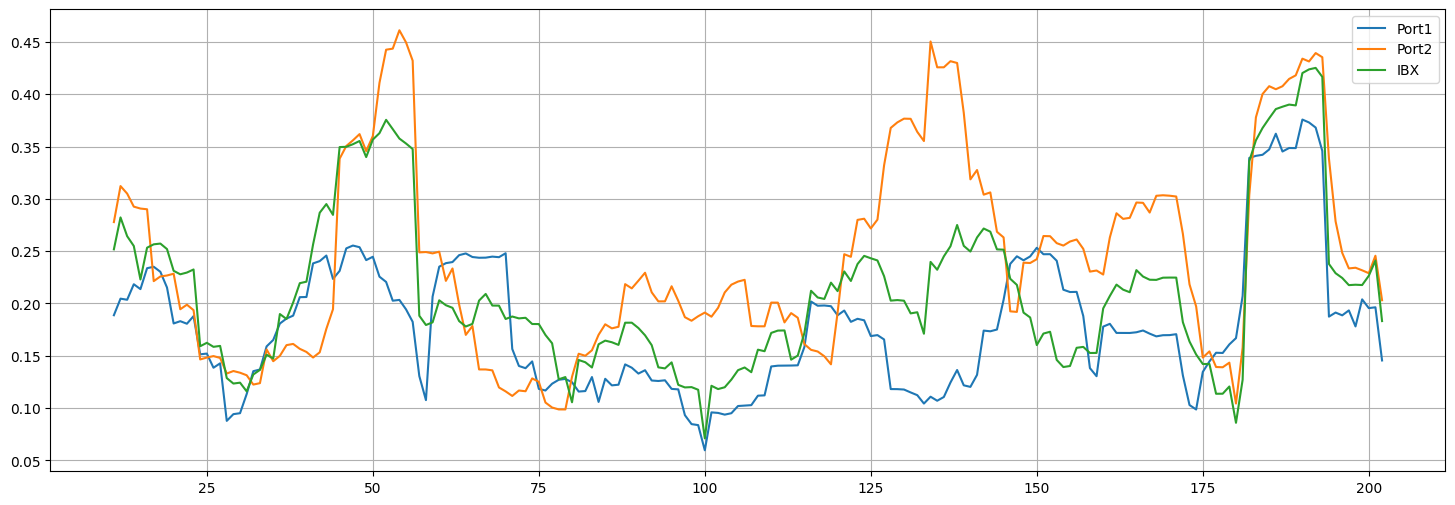

In [ ]:
#Volatilidade dos últimos 12 meses de um portfólio e de uma referência (IBX)
final_vol_df = pd.DataFrame()
final_vol_df['Port1'] = pd.Series(port_chg_vet1).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['Port2'] = pd.Series(port_chg_vet2).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df['IBX']   = pd.Series(ref_chg_vet).rolling(int(12/step_eval)).std()*(int(12/step_eval)**(1/2))
final_vol_df.plot(figsize=(18,6), grid=True);

<ipython-input-64-156cf7e4709e>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df12 = final_df12.append(final_temp, ignore_index=True)
<ipython-input-64-156cf7e4709e>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df12 = final_df12.append(final_temp, ignore_index=True)
<ipython-input-64-156cf7e4709e>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df12 = final_df12.append(final_temp, ignore_index=True)
<ipython-input-64-156cf7e4709e>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df12 = final_df12.append(final_temp, ignore_index=True)
<ipython-input-64-156cf7e4709e>:5: FutureWarning: The frame.append metho

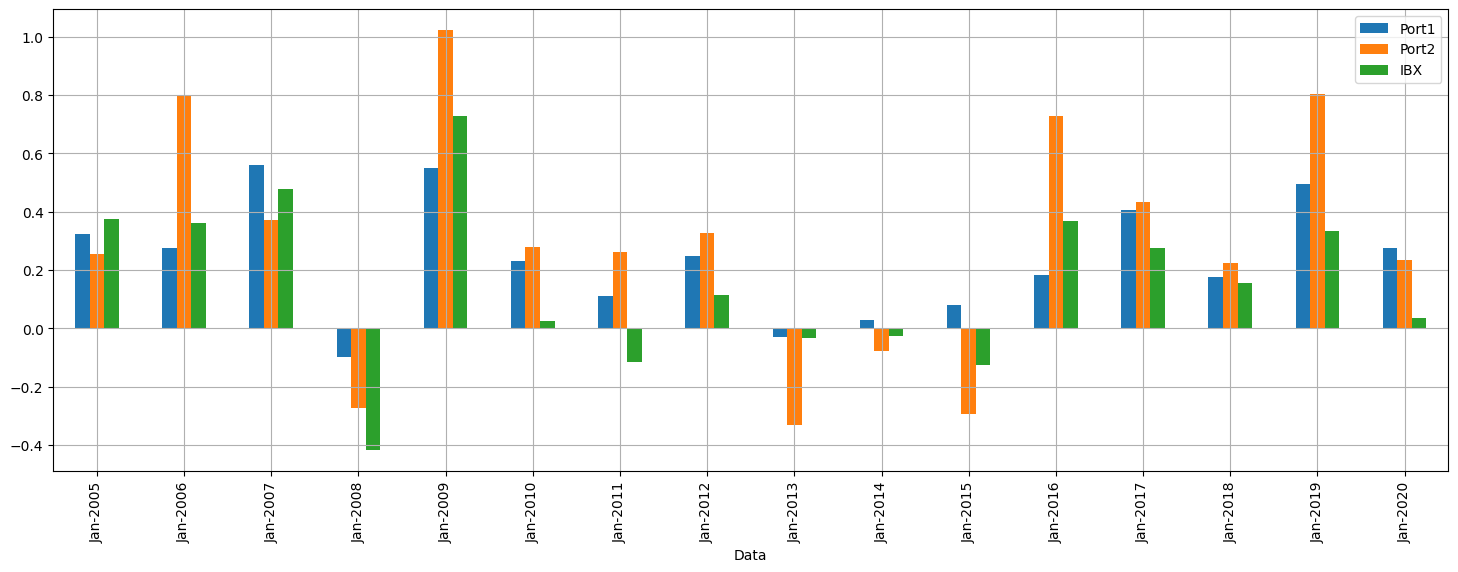

In [ ]:
#Retorno anual de um portfólio e de uma referência (IBX)
final_df12 = pd.DataFrame(columns=['Data', 'Port1', 'Port2', 'IBX'])
for ind in range(0, len(final_df.index)-12, 12):
  final_temp = final_df.iloc[ind+12]/final_df.iloc[ind]-1
  final_df12 = final_df12.append(final_temp, ignore_index=True)
  final_df12.iat[len(final_df12)-1, 0] = final_df.index[ind]

final_df12.set_index(keys = 'Data', inplace = True)

final_df12.plot.bar(figsize=(18,6), grid=True);
plt.show()